<a href="https://colab.research.google.com/github/Zsun79/Default-Prediction---American-Express-Data/blob/main/Predict_Credit_Default_American_Express_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Introduction

In this project, we predict the probability of credit default with the data provided by American Express, one of the world's largest payment companies. Credit default, in this case, is defined as the customer not paying back their credit card balance amount in the future based on their monthly profiles. A successful predictive model can help financial institutes risk management, leading to better customer service for cardholders.

The dataset provided by American Express includes a total of 190 variables with over 450,000 customers. The original dataset can be found [here](https://www.kaggle.com/competitions/amex-default-prediction/data). The target is a binary variable calculated by observing 18 months performance window after the latest credit card statement, and if the customer who does not pay due amount in 120 days after their latest statement date is considered as default.

The dataset contains aggregated profile features for each customer at each statement date. Features are anonymized and normalized, and fall into the following general categories:

D_* = Delinquency variables

S_* = Spend variables

P_* = Payment variables

B_* = Balance variables

R_* = Risk variables





In [ ]:
#@title
# Connect to the google drive.
# This will not work without permission

! pip install gdown --upgrade

import gdown
! gdown 1-4a0J7zgXbiBP6H7u8pHdymASg2yt_tj
! gdown 1-cmDQV144IU7uXg-AAAGHUotESWN4-vn

# update some packages
! pip install matplotlib==3.1.3

# import necessary package

import numpy as np 
import pandas as pd
import statsmodels.api as sm
from tqdm.auto import tqdm
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

#2. Exploratory Data Analysis

This table shows a small part of the whole dataset. As we can see, the column *customer_ID* is the unique ID assigned to customers, and column *S_2* is the date of the statement. For each customer, we have multiple but different numbers of statement entries, which we need to deal with before training the model.

In [2]:
#@title
# import raw data
data_raw = pd.read_parquet('train.parquet')
label_raw = pd.read_csv('train_labels.csv')
data_raw = pd.merge(data_raw,label_raw,on = 'customer_ID')
data_raw.set_index('customer_ID').head(20)
cat_features = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68",
]

In the practice of predicting credit default, the dataset is always unbalanced because most people will not default. In this project, the negative class, which is the default case, has already been subsampled at 5%. After downsampling, as shown in the figure below, the proportion of the target becomes 75% vs. 25%, which can be considered balanced for model training.

In [ ]:
#@title
# plot distribution of target

dist_target = data_raw['target'].value_counts().div(len(data_raw['target'])).mul(100)
fig, ax = plt.subplots(1,1, figsize=(15,8))
sns.barplot(x=dist_target.index, y=dist_target.values)
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.title("Target variable distribution")
plt.ylabel("Percentage [%]")
plt.show()

The following figure shows the proportion of predictors in each category. As shown in the figure, over half of the predictors belong to the category of delinquency, which is the critical variable for predicting default. On the other hand, the balance, risk, spend, and payment category accounts for 21%, 15%, 12%, and 2% of the full variables. The proportion of predictor category could be helpful information for feature engineering in practice.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


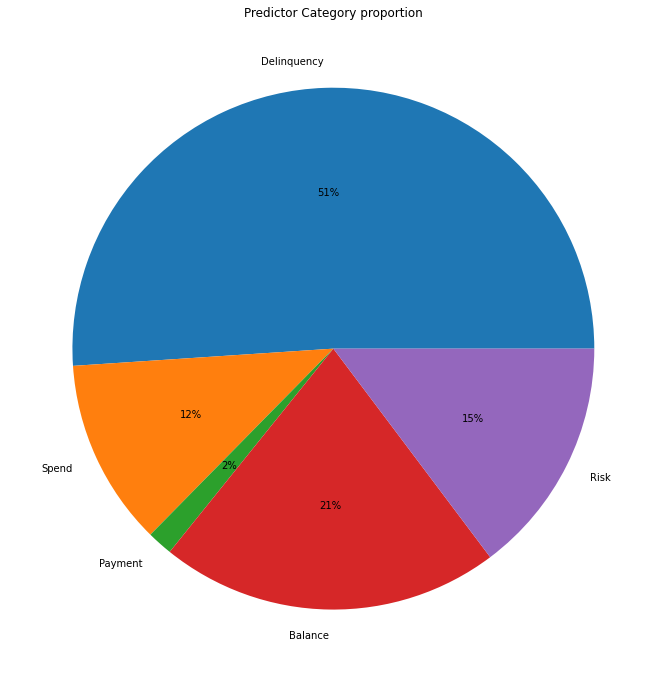

In [ ]:
#@title
# proportion of predictors' categories
cat_name = ['D','S','P','B','R']
cat_pie = pd.DataFrame(columns = ['name','proportion'])
for i in cat_name:
  tmp = {'name': i, 'proportion': len([c for c in data_raw.columns if i in c])}
  cat_pie = cat_pie.append(tmp,ignore_index= True)

cat_pie = cat_pie.set_index('name')

fig, ax = plt.subplots(1,1, figsize=(16,12))

labels_pie = ['Delinquency','Spend','Payment','Balance','Risk']
plt.pie(cat_pie.values, labels = labels_pie, autopct='%.0f%%')
ax.set_title('Predictor Category proportion')
plt.show()

Then we spend some time on missing observations in the dataset. The figure below shows the percentage of missing observations for each variable. Due to the space limitation, we only report the variables with over 0.5% missing observations. As shown in the figure, there are 11 variables which have over 80% missing data, which could affect their predictive power. We may drop some of the variables with a high percentage of missing value in the future. 

Missing value imputation is another thing we need to consider in most cases. There are several ways to fill the NaN value, such as imputing by mean or K-Nearest neighbor. In this project, we do not fill the missing values because we will use Boosted Tree (XGBoost and LightGBM) to fit the data, which could deal with the missing value automatically.

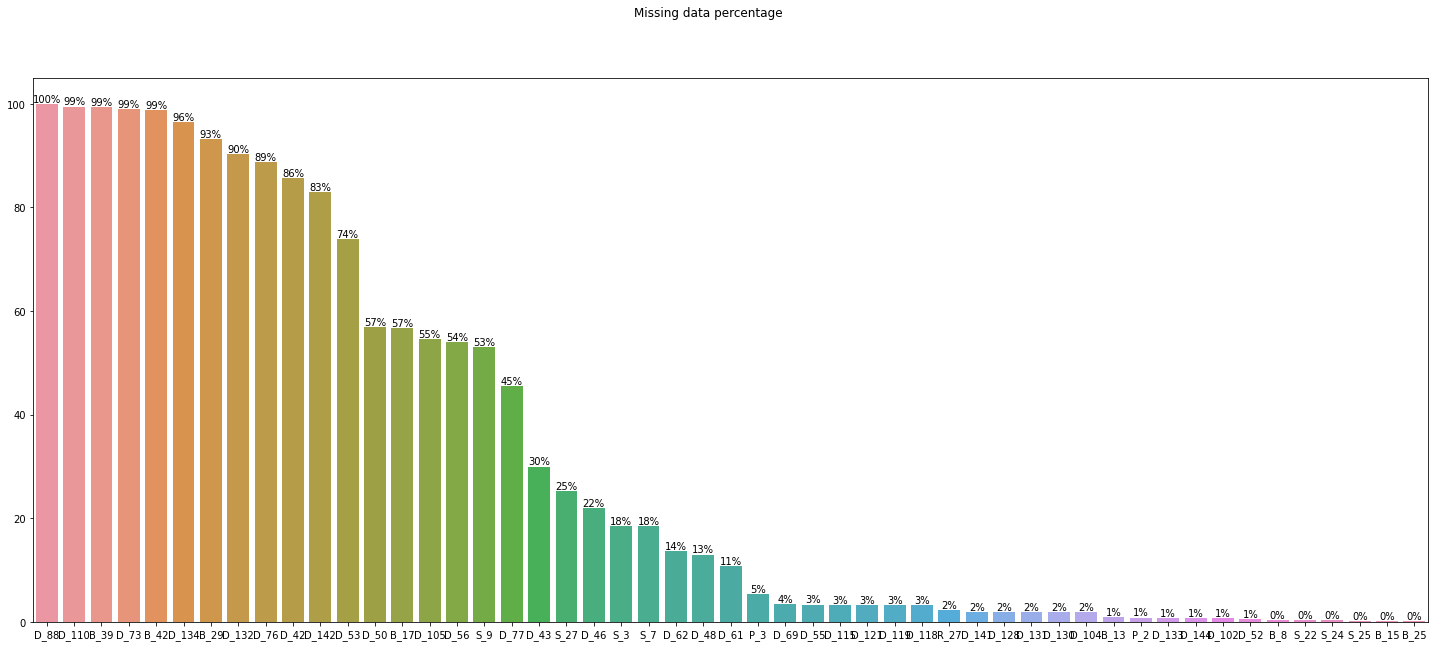

In [ ]:
#@title
# proportion of missing data
nan_num = data_raw.isna().sum().div(len(data_raw)).mul(100).sort_values(ascending = False)
sum(nan_num > 0.1)
fig, ax = plt.subplots(1,1, figsize=(25,10))
sns.barplot(x = nan_num[:51].index,y=nan_num[:51])
ax.bar_label(ax.containers[0], fmt='%.f%%')
plt.suptitle("Missing data percentage")
plt.show()

The next thing we want to investigate is the correlation between predictors. The figure below shows that most features' correlation is relatively small. Generally speaking, if the correlation is high, we could use PCA to extract helpful information with a small number of factors from a high-dimensional dataset. In this project, it seems that PCA could not be a good idea for feature engineering.

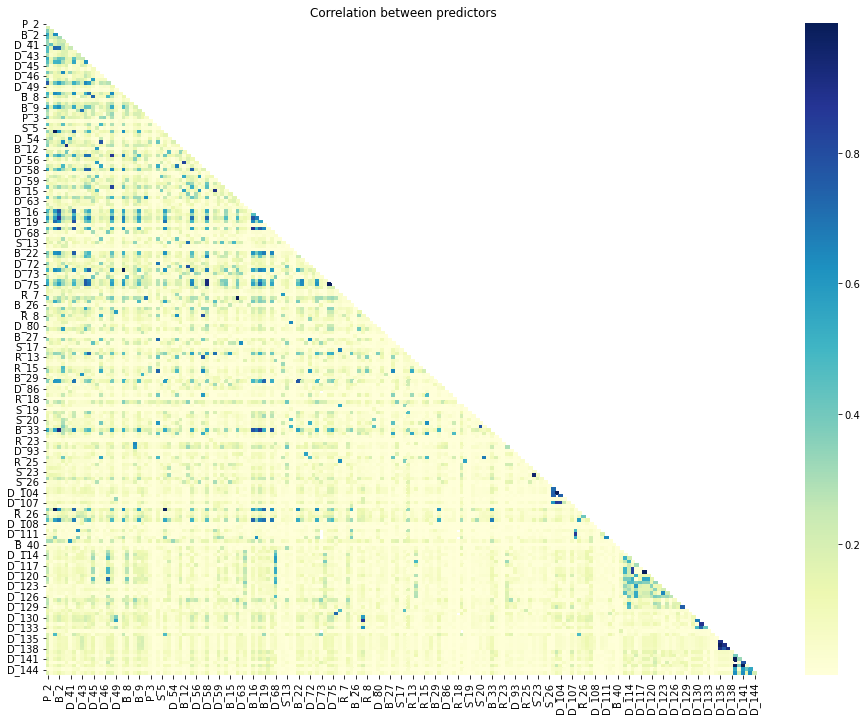

In [ ]:
#@title
#  Drop ID,date and target, then compute abs correlation between predictors
corr = data_raw.drop(columns=['customer_ID','S_2','target']).corr().abs() 

mask=np.triu(np.ones_like(corr))
fig, ax = plt.subplots(1,1, figsize=(16,12))
sns.heatmap(corr, ax=ax, mask=mask, cmap='YlGnBu')
ax.set_title("Correlation between predictors")
plt.show()

The last thing we want to investigate in this section is the correlation between targets and each feature, which implies the predictive power of each variable. As shown in the figure below, about 66% of predictors are weakly correlated to the target with a correlation coefficient lower than 0.2. On the other hand, only 21% of predictors have a correlation coefficient larger than 0.3. This implies that most of the predictors could not be decisive for predicting the credit default, and we might favor a relatively small model in the end. However, the correlation coefficient only measures the linear relationship between variables, and some of the predictors with low correlation could still be useful for prediction in a non-linear machine learning model. Therefore, we cannot rule out any features at this stage.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


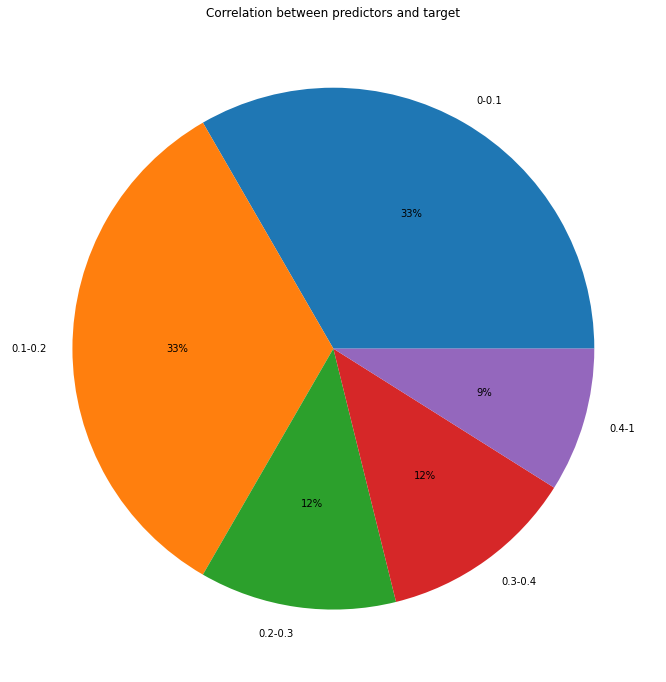

In [ ]:
#@title
# correlation to target
feature_name = data_raw.drop(columns=['customer_ID','S_2','target']).columns
corr_target = pd.DataFrame(columns = ['name','corr'])
#corr_target.loc[0] = 1
#corr_target.columns = feature_name
for i in feature_name:
  df2 = {'name': i, 'corr': data_raw[[i,'target']].corr().iloc[0,1]}
  corr_target = corr_target.append(df2, ignore_index = True)

corr_target = corr_target.set_index('name')
corr_target = corr_target.sort_values(by=['corr'],ascending = False)

fig, ax = plt.subplots(1,1, figsize=(16,12))
ranges = [0,0.1,0.2,0.3,0.4,1]
corr_target_pie = corr_target.groupby(pd.cut(corr_target['corr'], ranges)).count().div(len(corr_target)).mul(100)
labels_pie = ['0-0.1','0.1-0.2','0.2-0.3','0.3-0.4','0.4-1']
plt.pie(corr_target_pie, labels = labels_pie, autopct='%.0f%%')
ax.set_title('Correlation between predictors and target')
plt.show()

#3. Feature Engineering

In this section, we will transform the raw data into new features that can be fitted into the machine learning model. In practice, feature engineering is a critical step to a successful project. 

In this project, because we have multiple entries across different months for each customer, we need to group them into a single entry so that it can be used in model training more efficiently. 

In the first step, we group the data by computing the mean, standard deviation, minimum, and maximum, counting the number of entries, and obtaining the first and last values in the group.

After that, we compute more features by take the difference, ratio and percentage change between the features that have been created in the last stage:

**Difference**: last - *

**Ratio**: last / *

**Percentage change**: (last - * ) / ((last + * )/2)

The feature engineering steps generate 3950 features in total. The following table shows a example of the generated features.


In [8]:
#@title
# define some functions 
def get_difference(data, num_features,diff_order = 1):
    df1 = []
    customer_ids = []
    for customer_id, df in tqdm(data.groupby(['customer_ID'])):
        diff_df1 = df[num_features].diff(diff_order).iloc[[-1]].values.astype(np.float32)
        df1.append(diff_df1)
        customer_ids.append(customer_id)
    df1 = np.concatenate(df1, axis = 0)
    df1 = pd.DataFrame(df1, columns = [col + '_diff' + str(diff_order) for col in df[num_features].columns])
    df1['customer_ID'] = customer_ids
    return df1

def percent_change_midpoint(init,final):
  value = (final - init)/abs(final+init/2)*100
  both_zero = (final == 0) & (init == 0)
  value[both_zero] = 0
  return value

In [ ]:
#@title
# obtain all the features' name
features_name = data_raw.columns.drop(['S_2','customer_ID','target']) 
# name of numeric features
num_features = [col for col in features_name if col not in cat_features]
# name of integer features
int_features = [col for col in features_name if 'int' in str(data_raw[col].dtypes) and col not in cat_features]
# group the data by customer_ID, get the first and last value, compute the mean, standard deviation, minimum, maximum, and count the number of entries
train_group_agg = data_raw.groupby("customer_ID")[num_features].agg(['first','mean', 'std', 'min', 'max','last','count'])

# We first deal with numeric data
# For the integers, make sure all the value larger than 1.
for col in int_features:
  min_temp = min(train_group_agg[col]['last'])
  if min_temp < 0:
    train_group_agg[col]['last'] = train_group_agg[col]['last'] + abs(min_temp)+1

# Compute the difference, ratio, and percentage change
train_group_column = list(train_group_agg.columns)
for col in tqdm(num_features):
  # take difference between last to other
  train_group_agg[col + '_sub_first'] = train_group_agg[col]['last'] - train_group_agg[col]['first']
  train_group_agg[col + '_sub_mean'] = train_group_agg[col]['last'] - train_group_agg[col]['mean']
  train_group_agg[col + '_sub_min'] = train_group_agg[col]['last'] - train_group_agg[col]['min']
  train_group_agg[col + '_sub_max'] = train_group_agg[col]['last'] - train_group_agg[col]['max']
  train_group_agg[col + '_sub_std'] = train_group_agg[col]['last'] - train_group_agg[col]['std']
  # take ratio between last to other
  train_group_agg[col + '_div_first'] = train_group_agg[col]['last']/train_group_agg[col]['first']
  train_group_agg[col + '_div_mean'] = train_group_agg[col]['last']/train_group_agg[col]['mean']
  train_group_agg[col + '_div_min'] = train_group_agg[col]['last']/train_group_agg[col]['min']
  train_group_agg[col + '_div_max'] = train_group_agg[col]['last']/train_group_agg[col]['max']
  train_group_agg[col + '_div_std'] = train_group_agg[col]['last']/train_group_agg[col]['std']
  # take percentage change between last to other
  train_group_agg[col + '_percent_first'] = train_group_agg[col]['first']/train_group_agg[col]['last']
  train_group_agg[col + '_percent_mean'] = percent_change_midpoint(train_group_agg[col]['mean'],train_group_agg[col]['last'])
  train_group_agg[col + '_percent_min'] = percent_change_midpoint(train_group_agg[col]['min'],train_group_agg[col]['last'])
  train_group_agg[col + '_percent_max'] = percent_change_midpoint(train_group_agg[col]['max'],train_group_agg[col]['last'])

  # rename the features' name
train_group_column = ['_'.join(x) for x in train_group_column]
train_group_column_temp = train_group_agg.columns
train_group_column_temp = train_group_column_temp[len(train_group_column):len(train_group_column_temp)]
gc.collect()
train_group_column_extra = [(train_group_column_temp[i][0]) for i in range(len(train_group_column_temp))]
train_group_column = train_group_column + train_group_column_extra
train_group_agg.columns = train_group_column

# then we deal with the categorical data
for col in cat_features:
  if min(data_raw[col]) < 0:
    data_raw[col] = data_raw[col] + abs(min(data_raw[col]))

train_cat_agg = data_raw.groupby("customer_ID")[cat_features].agg(['first', 'last','nunique','count'])
train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]

# rename the features
for col in cat_features:
    change_temp = train_cat_agg[col+'_first'] - train_cat_agg[col+'_last']
    train_cat_agg[col+'_change'] = change_temp
    train_group_agg[col+'_first'] = train_cat_agg[col+'_first']
    train_group_agg[col+'_last'] = train_cat_agg[col+'_last']
    train_group_agg[col+'_nunique'] = train_cat_agg[col+'_nunique']
    train_group_agg[col+'_count'] = train_cat_agg[col+'_count']
    train_group_agg[col+'_change'] = train_cat_agg[col+'_change']
    
gc.collect()

# take difference between last and lag 1
train_diff = get_difference(data_raw, num_features,1)
train_diff = train_diff.set_index('customer_ID')
for i in tqdm(train_diff.columns):
  train_group_agg[i] = train_diff[i]
del train_diff
gc.collect()

# change float64 into float32 to save memory
float64_index = train_group_agg.columns[train_group_agg.dtypes == 'float64']
for col in float64_index:
  train_group_agg[col] = train_group_agg[col].astype(np.float32)

# concat the features with target
train_group_agg['target'] = data_raw.groupby("customer_ID")['target'].mean()
train_group_agg[train_group_agg.columns[(train_group_agg.dtypes == 'int64')]] = train_group_agg[train_group_agg.columns[(train_group_agg.dtypes == 'int64')]].astype(np.int8)
train_group_agg['target'] = train_group_agg['target'].astype(np.int8)
train_group_agg[train_group_agg.columns[(train_group_agg.dtypes == 'float64')]] = train_group_agg[train_group_agg.columns[(train_group_agg.dtypes == 'float64')]].astype(np.float32)




In [7]:
#@title
train_group_agg.head(10)

,P_2_first,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,P_2_count,D_39_first,D_39_mean,D_39_std,...,D_137_diff1,D_138_diff1,D_139_diff1,D_140_diff1,D_141_diff1,D_142_diff1,D_143_diff1,D_144_diff1,D_145_diff1,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.938469,0.933824,0.024194,0.868580,0.960384,0.934745,13,0,0.230769,0.832050,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,-0.003376,0.0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.929122,0.899820,0.022119,0.861109,0.929122,0.880519,13,13,7.153846,6.743468,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000641,0.0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.876615,0.878454,0.028911,0.797670,0.904482,0.880875,13,0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,-0.006491,0.0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.567442,0.598969,0.020107,0.567442,0.623392,0.621776,13,9,1.538462,3.017045,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000741,0.0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.936842,0.891679,0.042325,0.805045,0.940382,0.871900,13,0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.000618,0.0,0
000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c,0.784366,0.794131,0.019167,0.765181,0.824061,0.824061,13,2,6.538462,8.150822,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,0.003894,0.0,0
000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4,0.374606,0.444606,0.065085,0.328983,0.560474,0.477116,13,1,0.230769,0.438529,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,-0.004722,0.0,0
0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4cb59b50fec59e0b6381,1.002492,1.005816,0.003309,1.000488,1.009762,1.009762,13,17,11.846154,7.312616,...,0.0,0.0,0.0,0.0,0.000000,NaN,0.0,-0.001965,0.0,0
0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85,0.400025,0.406705,0.009116,0.391495,0.424624,0.424624,13,0,4.076923,7.170094,...,0.0,0.0,0.0,0.0,0.004601,0.000249,0.0,-0.006021,0.0,1


Because the number of features is enormous, we could select a smaller subset containing the most helpful information for predicting credit default. This feature selection step could decrease the cost of training machine learning models and achieve more robust out-of-sample performance.

In this project, we apply two different strategies for variable selection: backward and forward selection. Both strategies are based on the model we will use later, in this case, XGBoost and LightGBM.

Backward strategy: we start with a model including all variables. Then we drop a subset of 100 variables with the smallest importance and compare whether the metric increase or not. We keep dropping subsets until the model performs worse than before.

Forward strategy: we first run a model with full features and rank the importance of features. Then we start with a small model only including 500 features. Then we keep adding a subset of 100 variables with the largest importance until the model's performance is stable.

Based on the variable selection strategies, we decide to keep 2911 features, which is much smaller than the original features set.



#4. Model Training: LightGBM & XGBoost

In this project, we will use two Gradient Boosting Model: LightGBM, XGBoost.

Before we train the model, we split the dataset into two components: 75% training samples vs. 25% test samples. For the training set, we use 5-fold cross validation to train the model. 

In [10]:
#@title
from sklearn.model_selection import train_test_split
train_size = 0.75
test_size = 1-train_size
x_train, x_test, y_train, y_test = train_test_split(train_group_agg.drop(columns = 'target'), train_group_agg['target'], test_size=0.25, random_state=42)



The [evaluation metric](https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation) is the mean of two measures: normalized Gini coefficients, G, and default rate captured at 4%, D:

M = 0.5×(G+D)

where the default rate captured at 4% is the percentage of the positive labels (defaults) captured within the highest-ranked 4% of the predictions, and represents a Sensitivity/Recall statistic.



In [11]:
#@title
# define evaluation metrix

def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true, y_pred]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])
    gini = [0,0]
    for i in [1,0]:
        labels = np.transpose(np.array([y_true, y_pred]))
        labels = labels[labels[:, i].argsort()[::-1]]
        weight = np.where(labels[:,0]==0, 20, 1)
        weight_random = np.cumsum(weight / np.sum(weight))
        total_pos = np.sum(labels[:, 0] *  weight)
        cum_pos_found = np.cumsum(labels[:, 0] * weight)
        lorentz = cum_pos_found / total_pos
        gini[i] = np.sum((lorentz - weight_random) * weight)
    return 0.5 * (gini[1]/gini[0] + top_four)


def lgb_amex_metric(y_pred, y_true):
    y_true = y_true.get_label() 
    return 'amex_metric', amex_metric(y_true, y_pred), True


After we split the train/test set and define the evaluation metric, we move on to the model training and hyperparameter tuning.

We first focus on the LightGBM model. There are several hyperparameters that have cruicial impact on the performance of LightGBM. To do the hypermaraeters tuning efficiently, we focus on four main parameters that controls the complexity of the model: 

(1) num_leaves: number of leaves in each tree model

(2) learning rate: learning rate between trees

(3) feature_fraction: features subsampling fraction (number of columns)

(4) bagging_fraction: bagging fraction (number of rows)

(5) lambda_l2: l-2 penalty in each tree model

(6) min_data_in_leaf: minimum number of observation in each leaf

Below is an example of hyperparameters grid search:

In [46]:
#@title
import itertools

num_leaves = [64,128,256]
learning_rate = [0.005,0.01,0.02]
feature_fraction = [0.1,0.2,0.5]
bagging_fraction = [0.2,0.5,0.8]
lambda_2 = [0,0.5,1,2]   
min_data_in_leaf = [256,512,1024,2048]

a = [num_leaves,learning_rate,feature_fraction,bagging_fraction,lambda_2,min_data_in_leaf]
grid = list(itertools.product(*a))
hyper_grid = pd.DataFrame(columns = ['num_leaves','learning_rate','feature_fraction','bagging_fraction','lambda_2','min_data_in_leaf'])
for i in iter(grid):
  i_temp= pd.DataFrame([i],columns = ['num_leaves','learning_rate','feature_fraction','bagging_fraction','lambda_2','min_data_in_leaf'])
  hyper_grid = hyper_grid.append(i_temp)

hyper_grid.reset_index().drop(columns = 'index')

,num_leaves,learning_rate,feature_fraction,bagging_fraction,lambda_2,min_data_in_leaf
0,64,0.005,0.1,0.2,0,256
1,64,0.005,0.1,0.2,0,512
2,64,0.005,0.1,0.2,0,1024
3,64,0.005,0.1,0.2,0,2048
4,64,0.005,0.1,0.2,0.5,256
...,...,...,...,...,...,...
1291,256,0.020,0.5,0.8,1,2048
1292,256,0.020,0.5,0.8,2,256
1293,256,0.020,0.5,0.8,2,512
1294,256,0.020,0.5,0.8,2,1024


The step of hyperparameters tuning has been done in an independent notebook. Here we just directly use the selected hyperparameters for our predictive LightGBM model. Specifically, the hyperparameters set is summarized as follows:

In [ ]:
params = {
    'objective': 'binary',
    'metric': "binary_logloss",
    'boosting': 'goss',
    'seed': 42,
    'num_leaves': 128,
    'learning_rate': 0.01,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.50,
    'n_jobs': -1,
    'lambda_l2':2,
     'min_data_in_leaf': 512
    }

In [ ]:
#@title
# training model with 5-fold CV
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(x_train, y_train)):
  
  x_train_kfold,x_val_kfold = x_train.iloc[trn_ind],x_train.iloc[val_ind]
  y_train_kfold,y_val_kfold = y_train.iloc[trn_ind],y_train.iloc[val_ind]
  lgb_train = lgb.Dataset(x_train_kfold, y_train_kfold,categorical_feature = cat_features)
  lgb_valid = lgb.Dataset(x_val_kfold, y_val_kfold,categorical_feature = cat_features)

  del x_train_kfold,x_val_kfold,y_train_kfold,y_val_kfold
  gc.collect()

  num_round = 10500
  if fold >-1:
    lgb_model = lgb.train(params = params,
          train_set = lgb_train,
          num_boost_round = 10500,
          valid_sets = [lgb_train, lgb_valid],
          early_stopping_rounds = 1000,
          verbose_eval = 1000,
          categorical_feature = cat_features,
          feval = lgb_amex_metric)
    lgb_model.save_model(f"lgbm_{fold}_seed{42}_1.txt")

Then we move forward to the XGBoost model. Similarly, we start with hyperparameters tuning by grid searching. The hyperparameters in XGBoost is pretty much the same as LightBoost. We specifically focus on the following:

(1) max_leaf_nodes: maximum number of leaves in each tree model

(2) eta: learning rate between trees

(3) colsample_bytree: features subsampling fraction (number of columns)

(4) subsample: bagging fraction (number of rows)

(5) lambda: l-2 penalty in each tree model

Below is an example of hyperparameters grid search:



In [6]:
#@title
import itertools

num_leaves = [64,128,256]
learning_rate = [0.005,0.01,0.02]
feature_fraction = [0.1,0.2,0.5]
bagging_fraction = [0.2,0.5,0.8]
lambda_2 = [0,0.5,1,2]  

a = [num_leaves,learning_rate,feature_fraction,bagging_fraction,lambda_2]
grid = list(itertools.product(*a))
hyper_grid = pd.DataFrame(columns = ['max_leaf_nodes','eta','colsample_bytree','subsample','lambda'])
for i in iter(grid):
  i_temp= pd.DataFrame([i],columns = ['max_leaf_nodes','eta','colsample_bytree','subsample','lambda_2'])
  hyper_grid = hyper_grid.append(i_temp)

hyper_grid.reset_index().drop(columns = 'index')

,max_leaf_nodes,eta,colsample_bytree,subsample,lambda,lambda_2
0,64,0.005,0.1,0.2,NaN,0.0
1,64,0.005,0.1,0.2,NaN,0.5
2,64,0.005,0.1,0.2,NaN,1.0
3,64,0.005,0.1,0.2,NaN,2.0
4,64,0.005,0.1,0.5,NaN,0.0
...,...,...,...,...,...,...
319,256,0.020,0.5,0.5,NaN,2.0
320,256,0.020,0.5,0.8,NaN,0.0
321,256,0.020,0.5,0.8,NaN,0.5
322,256,0.020,0.5,0.8,NaN,1.0


Similarly, we have done the hyperparameters tuning step in an independent notebook. Here we just directly use the selected hyperparameters for our predictive XGBoost model. Specifically, the hyperparameters set is summarized as follows:

In [ ]:
params = {
            'objective': 'binary:logistic',
            #'booster':'goss', 
            #'tree_method': 'gpu_hist', 
            'max_leaf_nodes': 128,
            'subsample':0.5,
            'colsample_bytree': 0.2,
            'gamma':0.1,
            'min_child_weight':4,
            'lambda':2,
            'eta':0.01,
    }

In [ ]:
#@title
# training XGBoost with 5-fold CV
import xgboost as xgb
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(x_train, y_train)):
  if fold in [4]:
    x_train_kfold,x_val_kfold = x_train.iloc[trn_ind],x_train.iloc[val_ind]
    y_train_kfold,y_val_kfold = y_train.iloc[trn_ind],y_train.iloc[val_ind]

    
    dtrain = xgb.DMatrix(data= x_train_kfold, label= y_train_kfold)#enable_categorical=True)
    dvalid = xgb.DMatrix(data= x_val_kfold, label= y_val_kfold)#enable_categorical=True)
    
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    bst = xgb.train(params, dtrain=dtrain,
                num_boost_round=20500,evals=watchlist,
                early_stopping_rounds=1000, 
                feval= xgb_amex,
                maximize= True,
                verbose_eval=2000)
    bst.save_model(f"xgb_{fold}_seed{42}_1.txt")
    del dtrain, dvalid,x_train_kfold,x_val_kfold,y_train_kfold,y_val_kfold,bst
    gc.collect()
    

# Prediction & Evaluation


After model training, we will generate predictions based on each model. The value of predictions represents the probability of credit default, so it ranges from 0 to 1. Following table shows an example of predicted value:

In [ ]:
#@title
# Here we load trained models from google drive. These models are trained from the code above
! gdown 1RlRWzYyCzYqV6f8EFqO35_0xIsi7-MFh
! gdown 18aGLVsTnH0rQDlQ2P0U-XUlfxxvGePQG
! gdown 1-3fS8rO01oiDbA_LN9ntC1hfad1ym4uW
! gdown 1Pq5rnuaLv9-aXHzWVK5D2ZkfUefBR7RH
! gdown 1Znb6OIsZS3iJRP4A4qURI1nxUM6da6WG
! gdown 1CHBiGCBwVm9OyBoa8OjkHydahT17_qrX
! gdown 1-3ab3aH9MLDHOcxR9K_JbC4cmm9zedDx
! gdown 1qmxylnC7IOFEee2xvDTNbKwb_IyHa0mW
! gdown 1-3Lus8MqQOJhlfEHmJyMOyMd0Rq81btG
! gdown 1-9UEueX5q8rOnC7Rp2v_H4-Os9x6h5ca
! gdown 1MecUcoRDQOovFi21FmNrIdZeBrQtxFpb

In [ ]:
#@title
import xgboost as xgb

name_exclude = pd.read_csv('name_exclude.csv')
name_exclude = name_exclude['index']
x_test = x_test.drop(columns = name_exclude)
# generate predictions LGBM
index_temp = 0
size = np.ceil(len(x_test)/6).astype(np.int64)
predict_temp = list()
predict_results = pd.DataFrame()
# forloop over CV fold
for k in tqdm(range(0,5)):
  lgbm_temp = lgb.Booster(model_file = f'lgbm_{k}_seed42_1.txt')
  index_temp = 0
  # split the data into smaller set, avoid memory crash
  for i in range(6):
    predict_temp[index_temp:index_temp+size] = lgbm_temp.predict(x_test.iloc[index_temp:index_temp+size])
    index_temp +=size
  predict_results[f'lgbm_{k}'] = predict_temp

predict_results['lgbm_mean'] = predict_results.mean(axis = 1)

# generate predictions XGBoost
index_temp = 0
size = np.ceil(len(x_test)/3).astype(np.int64)
predict_mean = list()
predict_temp = list()
# forloop over CV fold
for k in range(5):
  xgb_temp = xgb.Booster()
  xgb_temp.load_model(f'xgb_{k}_seed42_1.txt')
  index_temp = 0
  # split the data into smaller set, avoid memory crash
  for i in range(3):
    x_test_temp = xgb.DMatrix(x_test.iloc[index_temp:index_temp+size])#enable_categorical=True)
    predict_temp[index_temp:index_temp+size] = xgb_temp.predict(x_test_temp)#,prediction_type= 'Probability')
    index_temp += size
  predict_results[f'xgboost_{k}'] = predict_temp
  #predict_mean = predict_mean + predict_temp

predict_results['xgboost_mean'] = predict_results[['xgboost_0','xgboost_1','xgboost_2','xgboost_3','xgboost_4']].mean(axis = 1)
predict_results['all_mean'] = predict_results.mean(axis = 1)

# show result
predict_results.head(10)

After generating the predictions, we will evaluate the performance of each model. The following table shows the performance of models in terms of the metric we have defined before. The metric ranges from 0 to 1, and a higher value implies accurate predictions. As we can see, the performance of the model trained by each fold of data is worse than the average of all the folds. And the combination of LightGBM and XGboost yields a better performance than each of them, which implies the ensemble model is helpful for the overall performance.

In [42]:
#@title
# proportion of missing data
metric = pd.DataFrame([np.empty(13,)],columns = predict_results.columns)
metric_col = []
for i in predict_results.columns:
  metric.iloc[0][i] = amex_metric(y_test,predict_results[i])
  #metric_col = metric_col + [i]

metric

,lgbm_0,lgbm_1,lgbm_2,lgbm_3,lgbm_4,lgbm_mean,xgboost_0,xgboost_1,xgboost_2,xgboost_3,xgboost_4,xgboost_mean,all_mean
0,0.793566,0.792851,0.794486,0.793087,0.7931,0.79528,0.792439,0.793203,0.79345,0.794089,0.793231,0.795443,0.796192


In summary, this project investigates how to predict credit default by LightGBM and XGBoost model. The keys to improving performance are feature engineering and hyperparameter tuning.

Due to the limitation of computational cost, we only did a relatively simple example of the task, and we can definitely improve the performance in a real-world scenario. For instance, we can expand the set of features and narrow the whole group into a smaller set of features with a more sophisticated feature selection step. We can also find a better way to ensemble models instead of taking a simple average. 